## <center> <U> Spotify Business of Rhythm

**Problem Statement**

Provide business recommendations to Spotify by analyzing available data, which includes:-
1.	Analysis of the hour of the day to generate recommendations on the following problem statements:

    a. Computing the number of times each context type is played
    during the time of observation.

    b. Finding the optimum hour of the day by analysing the number of active users to promote under-performing context types.

    c. Learning how various context types are permorming during each hour of the day and drawing conclusions out of it.
    
    
2.	Predicting whether a song would be skipped or not by taking into consideration correspondingly other significant factors.

    
3. Inferencing the trend of various track features with years


## Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp

import warnings
warnings.simplefilter("ignore")

## Importing the Datasets

In [2]:
session = pd.read_csv('../data/session_info.csv')
Track_feature = pd.read_csv('../data/track_features.csv')

In [3]:
session.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,...,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [4]:
Track_feature.head()

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,t_a540e552-16d4-42f8-a185-232bd650ea7d,109.706673,1950,99.975414,0.458040,0.519497,0.504949,0.399767,7.511880,0.817709,...,4,0.935512,-0.033284,-0.411896,-0.028580,0.349438,0.832467,-0.213871,-0.299464,-0.675907
1,t_67965da0-132b-4b1e-8a69-0ef99b32287c,187.693329,1950,99.969430,0.916272,0.419223,0.545530,0.491235,9.098376,0.154258,...,3,0.359675,0.145703,-0.850372,0.123860,0.746904,0.371803,-0.420558,-0.213120,-0.525795
2,t_0614ecd3-a7d5-40a1-816e-156d5872a467,160.839996,1951,99.602549,0.812884,0.425890,0.508280,0.491625,8.368670,0.358813,...,4,0.726769,0.021720,-0.743634,0.333247,0.568447,0.411094,-0.187749,-0.387599,-0.433496
3,t_070a63a0-744a-434e-9913-a97b02926a29,175.399994,1951,99.665018,0.396854,0.400934,0.359990,0.552227,5.967346,0.514585,...,4,0.859075,0.039143,-0.267555,-0.051825,0.106173,0.614825,-0.111419,-0.265953,-0.542753
4,t_d6990e17-9c31-4b01-8559-47d9ce476df1,369.600006,1951,99.991764,0.728831,0.371328,0.335115,0.483044,5.802681,0.721442,...,4,0.562343,0.131931,-0.292523,-0.174819,-0.034422,0.717229,-0.016239,-0.392694,-0.455496


## Merging Both the datasets:

We will merge both the datasets based on the common column track_id in order to find out the importance of all the features

In [5]:
data = session.merge(Track_feature, left_on='track_id_clean', right_on='track_id')
data.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
1,0_00079a23-1600-486a-91bd-5208be0c745a,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826


### Predicting which hour of the day the users have the highest favorability towards Spotify-generated playlist



**Data Cleaning :-**

We remove the rows which end with the backbutton and endplay. This is  because when a user presses the backbutton, it gives one no inference for the current song as the user wanted to listen to the previous song. The row where the previous song has been played and the current song plays again is what is statistically significant for us. We use the same logic in removing the rows ending with the endplay button. 

In [6]:
data1 = data[ (data['hist_user_behavior_reason_end'] == 'fwdbtn') |(data['hist_user_behavior_reason_end'] == 'trackdone') |(data['hist_user_behavior_reason_end'] == 'logout') |(data['hist_user_behavior_reason_end'] == 'remote') | (data['hist_user_behavior_reason_end'] == 'clickrow')] 
data1.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
2,0_012b0fb4-0cc3-429f-9a78-cc6e622153fb,6,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
3,0_013cc010-c476-4ad2-8972-73449e0b2ef4,9,13,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,1,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
4,0_01a5f0dc-9938-48c9-92f1-c7e51f34d290,7,12,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,True,False,0,0,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826
5,0_01f86af2-cf48-42a6-9bf8-adb91f072909,7,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,True,True,True,False,0,1,...,4,0.152255,-0.815775,0.386409,0.23016,0.028028,-0.333373,0.015452,-0.35359,0.205826


In [7]:
filter_unit = data1.sort_values(by=['hour_of_day'])
data2 = filter_unit.set_index('hour_of_day')
data3 = data2.groupby(['hour_of_day','context_type']).count()
data4 = data3[['session_id']]
data4 = data4.rename(columns={"session_id":"Counts"})
data4

Counts
hour_of_day context_type                 
0           catalog                  1071
            charts                     38
            editorial_playlist        944
            personalized_playlist      56
            radio                     585
...                                   ...
23          charts                    141
            editorial_playlist       1417
            personalized_playlist      72
            radio                     859
            user_collection          2341

[139 rows x 1 columns]

In [8]:
data4.sum() == data1.shape[0]
data4.reset_index(inplace=True)
data5 = data4
data5[data5.hour_of_day==0].Counts.sum()

hourly_counts = []

for i in np.arange(0,24,1):
  hourly_counts.append(data5[data5.hour_of_day==i].Counts.sum())

data5.head()

,hour_of_day,context_type,Counts
0,0,catalog,1071
1,0,charts,38
2,0,editorial_playlist,944
3,0,personalized_playlist,56
4,0,radio,585


**Data Visualization**

We assess which contect type is performing the best on the app and also the hour of the day where the usage of spotify is the highest. The range of data we have has is for two months

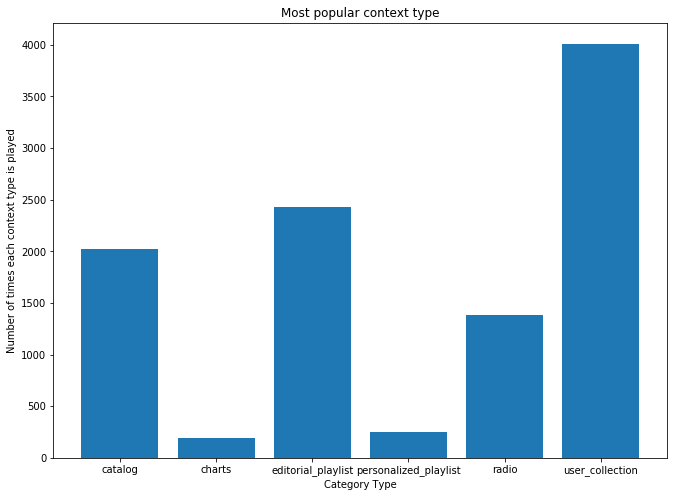

In [9]:
plt.figure(figsize=(11,8))
plt.bar(data5.context_type,data5.Counts)
plt.xlabel("Category Type")
plt.ylabel("Number of times each context type is played")
plt.title("Most popular context type")
plt.show()

**Inferences -**

1. We see that the track collection set by the user was the most popular during the period of observation. 

2. We also infer that Charts and personalized playlist for every user performed the worst. The under-performance of these types could be due to a couple of reasons. It could be due to the incoherance in the song list recommended or because these types were not marketed to their full potential on the application. To boost these context types we could improve our recommendation system or we could better market them by sending the users notifications or positioning them better on the app interface. 

**Scatter Plot signifying the number of active users based on the hour of the day**

In [10]:
filter_unit = []
for i in np.arange(0,24,1):
  for j in np.arange(0,len(data5),1):
    if data5.hour_of_day[j] == i:
      filter_unit.append(hourly_counts[i])
data5= data5.assign(Total=filter_unit)

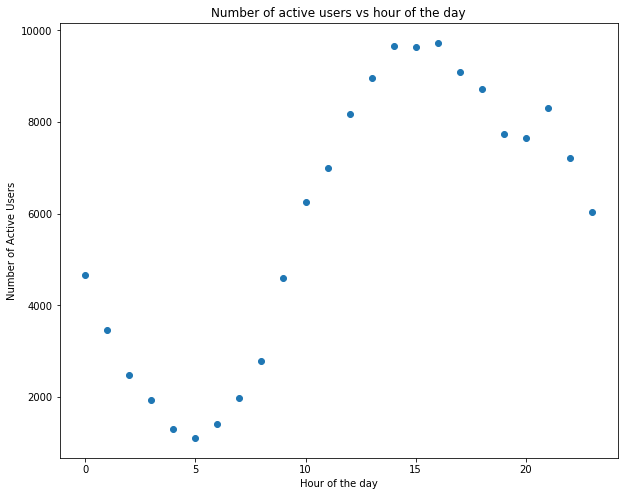

In [11]:
hours = data5.hour_of_day.unique()
Total = data5.Total.unique()
plt.figure(figsize=(10,8))
plt.scatter(hours,Total)
plt.xlabel("Hour of the day")
plt.ylabel("Number of Active Users")
plt.title("Number of active users vs hour of the day")
plt.show()

**Inferences -**

1. We see that the highest number of users on the application is in the afternoon around 3-4 pm. Hence, aggressive marketing at that time to promote the context type not performing well could improve the probability of those context types being played more number of times. 

2. The graph also gives us information about the hour of the day when the usage is the lowest which is in the morning at 5am. We also see that the usage decreases steeply at night reaches a low at 5am and then starts to increase after the break of dawn. 

**Plotting a Stack Bar Graph**

We further go deeper into each hour of the day and study which types were played during that hour. An additional analysis which is possible in this case is to study the mood of the users to promote mood specific songs in the underperforming context types.

In [12]:
Ratio = data5.Counts/data5.Total
data5= data5.assign(Percentage= 100*Ratio)

In [18]:
filter = pd.get_dummies(data5.context_type)
filter1 = (data5.Percentage) * (filter) 
filter2 = pd.DataFrame()

for i in range(0,len(filter)):
  filter1 = data5.Percentage[i] * filter.iloc[i:i+1,:]
  filter2 = filter2.append(filter1,ignore_index=True)
data6 = pd.concat([data5,filter2],axis=1)

In [21]:
data7 = data6.groupby(data6.hour_of_day).sum()
data7 = data7.assign(Total = sum(data7.Counts))
data7.head()

,Counts,Total,Percentage,catalog,charts,editorial_playlist,personalized_playlist,radio,user_collection
hour_of_day,,,,,,,,,
0,4675,139928,100.0,22.909091,0.812834,20.192513,1.197861,12.513369,42.374332
1,3456,139928,100.0,21.730324,0.000000,24.797454,1.649306,17.418981,34.403935
2,2480,139928,100.0,17.177419,0.000000,19.354839,3.225806,15.161290,45.080645
3,1949,139928,100.0,24.012314,0.000000,20.523345,2.924577,11.493073,41.046691
4,1308,139928,100.0,22.324159,1.681957,16.743119,1.299694,13.073394,44.877676


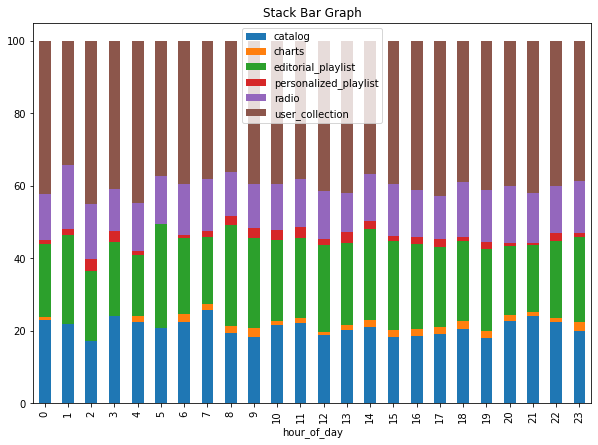

In [22]:
data7.iloc[:,3:].plot.bar(stacked=True, figsize=(10,7))
plt.title("Stack Bar Graph")
plt.show()

**Reducing the size of the data**

We initially created dummies for each categorical variable in order to accomodate them in the random forest algorithm later. In order to reduce the size of the dataset, we grouped the data based on session_ids and then randomly chose 2000 ids out of the 10000 unique ids. 

In [23]:
np.random.seed(40)
data2 = pd.get_dummies(data1, columns=['skip_2','not_skipped','hist_user_behavior_is_shuffle','mode','premium','context_type','hist_user_behavior_reason_start','hist_user_behavior_reason_end'])
data2 = data2.drop(['date', 'track_id','skip_2_False'], axis = 1) #Removing unnecessary columns
data2_group = data2.groupby(["session_id"]).count() #Grouping the dataset by the session_ids
data3_group = data2_group.sample(n = 2000) #Randomly choosing 2000 session_ids from the 10000 unique session ids
data3 = data2.set_index('session_id') #Setting the index of the original dataset to session id to chunk data in the next step
data4 = data3.loc[list(data3_group.index),:] #Matching the index of grouped data set with the original dataset
data5 = data4.reset_index() #Reseting index from session_id to original index

#Final dataset with lesser number of rows based on number of users
data5

,session_id,session_position,session_length,track_id_clean,skip_1,skip_3,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,...,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone
0,0_0069ec81-08a8-4b39-99f6-001b7d47063d,5,11,t_21d9979d-f502-4d8b-b3d3-6acd5a034143,False,False,0,0,1,1,...,0,0,0,1,0,0,0,0,0,1
1,0_0069ec81-08a8-4b39-99f6-001b7d47063d,4,11,t_30bb651f-c19d-4e48-9055-858e69911c3b,False,False,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
2,0_0069ec81-08a8-4b39-99f6-001b7d47063d,3,11,t_5475d096-3905-4fb7-8182-653dca9a5248,False,False,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0_0069ec81-08a8-4b39-99f6-001b7d47063d,8,11,t_dbe4870d-2251-469b-8c52-88b18406e721,False,False,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0_0069ec81-08a8-4b39-99f6-001b7d47063d,9,11,t_f4bb3971-f568-44ed-969a-d5a9cd9bf6e9,False,False,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28072,0_065f296e-4c65-4140-a4e2-bd8444b1f33f,4,20,t_3fb1c8de-12ab-4240-b6c2-f24a6de18f92,True,True,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
28073,0_065f296e-4c65-4140-a4e2-bd8444b1f33f,13,20,t_33521a94-5a2c-4220-a0ab-73798b9de15e,True,True,0,0,1,1,...,0,0,0,1,0,0,1,0,0,0
28074,0_065f296e-4c65-4140-a4e2-bd8444b1f33f,14,20,t_d0fe2f41-4540-4100-85cc-9bdfe388e4a8,False,True,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
28075,0_065f296e-4c65-4140-a4e2-bd8444b1f33f,15,20,t_f526499e-2976-467f-8bab-d270cd79e863,False,True,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0


**Random Forest Feature Prediction:**

We will use the random forest algorithm for the dataset to find which features affect the probability of skipping a song the most which is our outcome variable(skip)

**Creating training and testing datasets**

In [24]:
from sklearn.ensemble import RandomForestClassifier
Y = data5.loc[:, 'skip_2_True'] #Outcome variable
X1 = data5.iloc[:, 6:] 
X = X1.drop(["skip_2_True", "not_skipped_False", "not_skipped_True"], axis = 1)

In [25]:
from sklearn.model_selection import train_test_split
np.random.seed(40)
# Split the data into 30% test and 70% training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(X_train.shape, Y_train.shape)

(19653, 61) (19653,)


**Train a Random Forest Classifier**

Assigning weights to each feature based on it's importance in predicting whether a song would be skipped or not. 

In [26]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, Y_train)

# Print the name and gini importance of each feature
for feature in zip(list(X_train.columns), clf.feature_importances_):
    print(feature)

('context_switch', 0.0026953658352851626)
('no_pause_before_play', 0.006947756971110508)
('short_pause_before_play', 0.005136111353917298)
('long_pause_before_play', 0.005672117723964326)
('hist_user_behavior_n_seekfwd', 0.002638853028096748)
('hist_user_behavior_n_seekback', 0.004509742477619124)
('hour_of_day', 0.02531631807049506)
('duration', 0.01101576930491068)
('release_year', 0.005604681555355947)
('us_popularity_estimate', 0.010574958745140117)
('acousticness', 0.009365031542432688)
('beat_strength', 0.008899749515718569)
('bounciness', 0.008498177586938964)
('danceability', 0.008965286000647518)
('dyn_range_mean', 0.008701256173929257)
('energy', 0.009303200583577684)
('flatness', 0.009387488929210926)
('instrumentalness', 0.005784155370377693)
('key', 0.005656571799919434)
('liveness', 0.009937778527371335)
('loudness', 0.009543673281971308)
('mechanism', 0.009212363630149803)
('organism', 0.008930580595945422)
('speechiness', 0.009604734747300277)
('tempo', 0.00958313985899

**Identifying and Selecting the most important features from the dataset**

Create a selector object that will use the random forest classifier to identify the features that have an importance of more than 0.01

In [27]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(clf, threshold=0.011)

# Train the selector
sfm.fit(X_train, Y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                                 random_state=0),
                threshold=0.011)

In [28]:
#Finding the list of feature that are comparitively more important

for feature_list_index in sfm.get_support(indices=True):
    print(list(X_train.columns)[feature_list_index])

hour_of_day
duration
hist_user_behavior_reason_start_fwdbtn
hist_user_behavior_reason_start_trackdone
hist_user_behavior_reason_end_fwdbtn
hist_user_behavior_reason_end_trackdone


**After finding the relatively more important features, the next step would be to fit a logistic model with covariates to find the probability of skipping a song**

In [29]:
# Making a new dataframe with decision variable(SKIP2) appended to old dataframe for both the training and the testing data
y = Y_train
temp_train = X_train
temp_train = temp_train.assign(Decision = y)

#X_test
y = Y_test
temp_test = X_test
temp_test = temp_test.assign(Decision = y)

In [31]:
#Logit model with best features as mentioned above

from statsmodels.formula.api import logit
logit_model = logit('Decision ~ hour_of_day + duration + us_popularity_estimate\
+ C(hist_user_behavior_reason_start_fwdbtn) + C(hist_user_behavior_reason_start_trackdone)\
+ C(hist_user_behavior_reason_end_fwdbtn) + C(hist_user_behavior_reason_end_trackdone)',temp_train).fit()

Optimization terminated successfully.
         Current function value: 0.244751
         Iterations 10


In [32]:
print(logit_model.summary())

                           Logit Regression Results                           
Dep. Variable:               Decision   No. Observations:                19653
Model:                          Logit   Df Residuals:                    19653
Method:                           MLE   Df Model:                           -1
Date:                Mon, 27 Jul 2020   Pseudo R-squ.:                  0.6461
Time:                        19:15:56   Log-Likelihood:                -4810.1
converged:                       True   LL-Null:                       -13592.
Covariance Type:            nonrobust   LLR p-value:                       nan
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             2.1964      3.048      0.721      0.471      -3.777       8.170
C(hist_user_be

**Inference -**

1. We infer from the above model that out of the selected features, features such as hour of day, popularity and liveness are statistically insignificant features.

2. We can also infer that provided the other factors remain the same, a song which has started by pressing the forward button would have a higher probability of getting skipped. This might be due to the recommendation system of the application that puts songs of similar features together. 

3. Provided the other factors remain the same, a song which has started by the track getting over would have a lower probability of getting skipped. This might be due to the recommendation system of the application that puts songs of similar features together.

4. The model also rightly predicts the fact that a song ended by pressing the forward button has a high positive coefficient provided other factors remain the same. 

5. Provided the other factors remain the same, more the duration of the song lesser is the probability of the song getting skipped.  

In [33]:
#Predicted Probablities
#Here the Decision is the actual observation for the song and Predicted_prob is the prediction that we found out 
Predicted_prob = logit_model.predict(X_test)
temp_test = temp_test.assign(Predicted_prob = Predicted_prob)
temp_test[['Decision','Predicted_prob']].head(40)

,Decision,Predicted_prob
21556,0,0.508255
7939,0,0.013219
24701,0,0.013979
4532,0,0.001105
25506,1,0.914827
8255,1,0.465414
24380,1,0.905793
16213,0,0.903701
7460,0,0.001245
26498,0,0.000996


In [34]:
filter_unit = (temp_test['Decision']==1)
temp_1 = temp_test.loc[filter_unit,['Decision','Predicted_prob']]
temp_1.shape

(3980, 2)

There were 3980 rows are the number of songs which are predicted by the model to have skip Decision = 1 

In [35]:
filter_unit = temp_1["Predicted_prob"] > 0.5
temp_1[filter_unit].shape

(3618, 2)

In [36]:
Accuracy_1 = (temp_1[filter_unit].shape[0])/(temp_1.shape[0])
print("We can predict whether a song would get skipped with an accuracy of", Accuracy_1)

We can predict whether a song would get skipped with an accuracy of 0.9090452261306533


## Conclusion

As discussed above, there are multiple applications and uses of these results.

● To help companies build better recommendation systems by helping them predict whether a song will be skipped and which song should be played next.

● To help the marketing team with the analysis of different playlists at different hour of the day

● To help artists focus on important features to help them come up with a song that generate enough traction and popularity

## Video Link
https://drive.google.com/open?id=164MjU96ngjR-7HP1YjdZs42VVrCtWJ8z